In [1]:
!pip install pandas matplotlib networkx -q

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

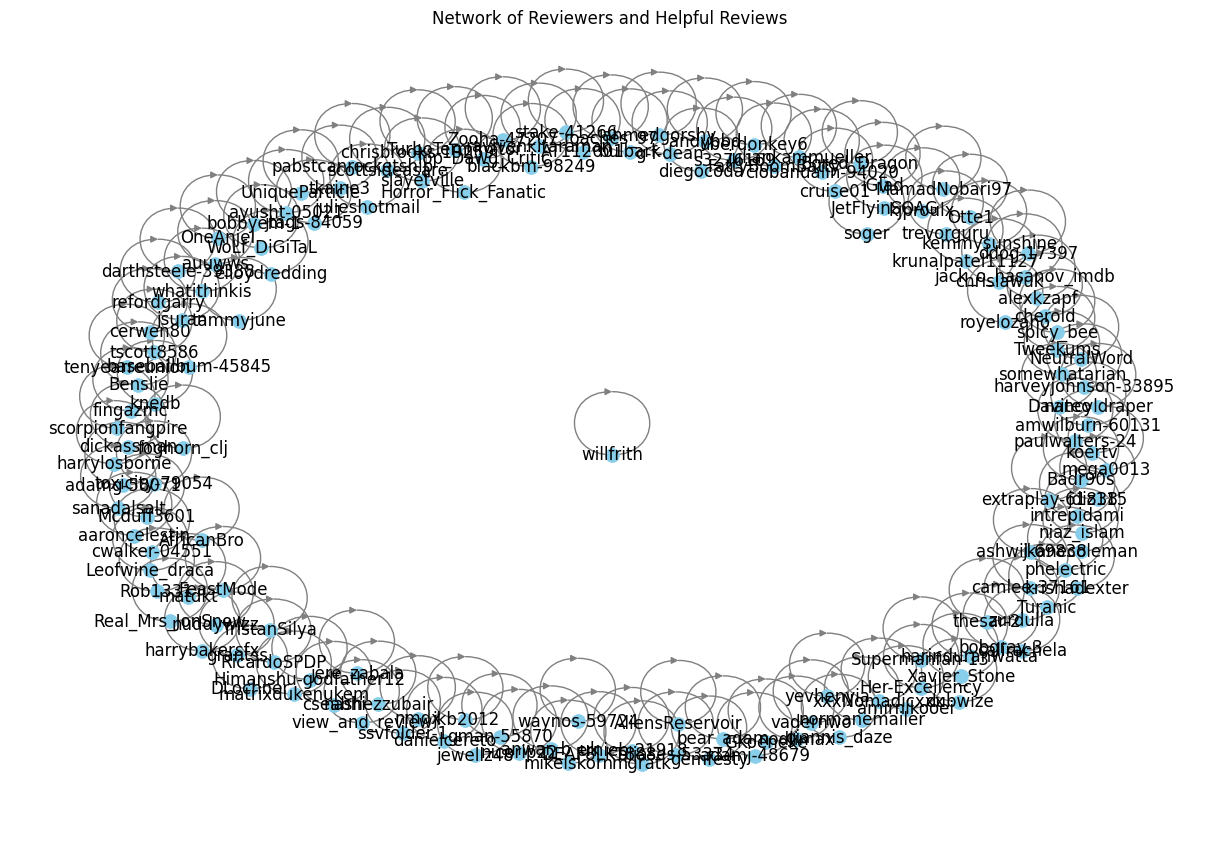

In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Load dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/WSMA_DJTY/the boys_imdb review.csv'
df = pd.read_csv(file_path)

# Preprocess data
# Assuming 'display-name-link' represents reviewers and 'actions' represents helpfulness count
# You may need to adjust column names accordingly
df['display-name-link'] = df['display-name-link'].str.split('/').str[-1]  # Extract reviewer IDs
df['actions'] = df['actions'].str.extract(r'(\d+)')  # Extract helpfulness count
df.dropna(subset=['display-name-link', 'actions'], inplace=True)  # Drop rows with missing data

# Create directed graph
G = nx.DiGraph()

# Add nodes (reviewers)
G.add_nodes_from(df['display-name-link'].unique())

# Add edges (helpfulness relationships)
for idx, row in df.iterrows():
    reviewer = row['display-name-link']
    helpfulness_count = int(row['actions'])
    G.add_edges_from([(reviewer, reviewer) for _ in range(helpfulness_count)])

# Visualize network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Position nodes using spring layout algorithm
nx.draw(G, pos, with_labels=True, node_size=100, node_color='skyblue', edge_color='gray', linewidths=0.5, arrowsize=10)
plt.title('Network of Reviewers and Helpful Reviews')
plt.show()

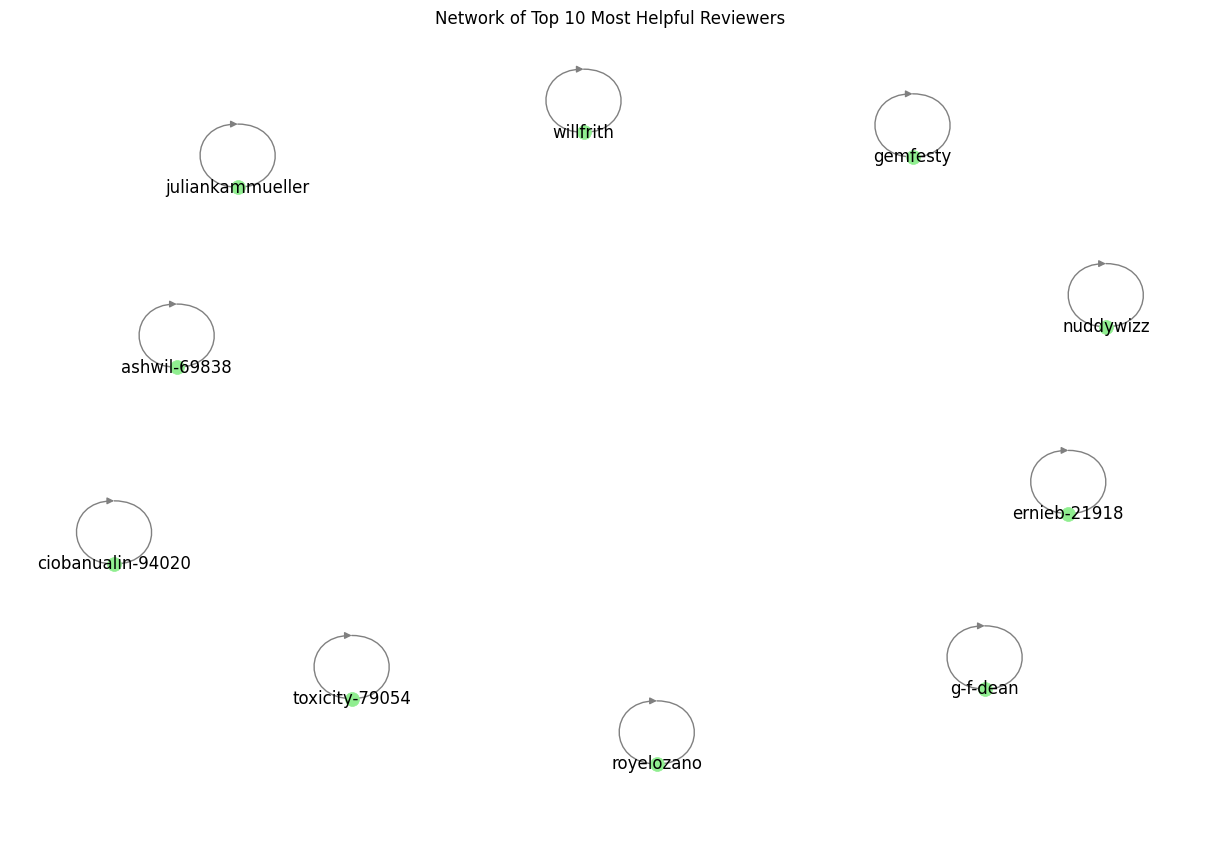

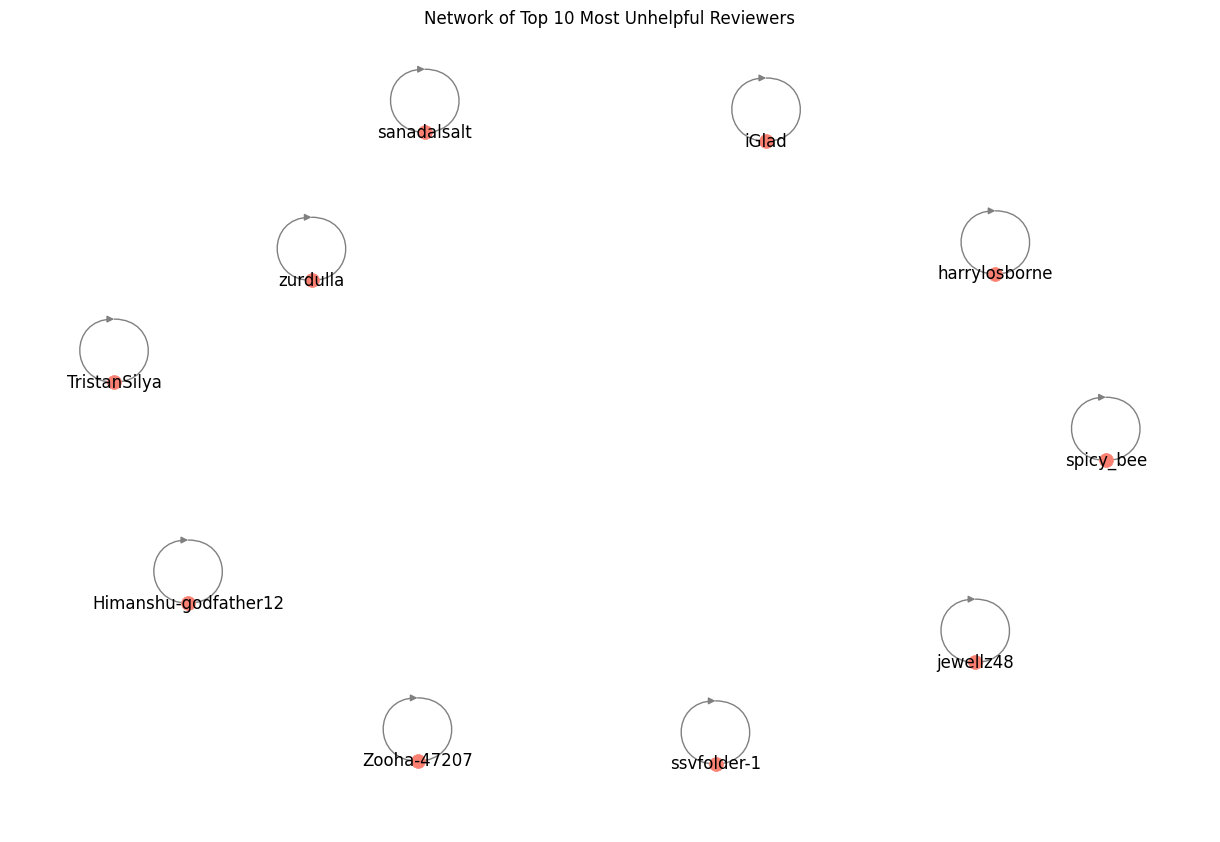

In [5]:
# Preprocess data to convert 'actions' column to numeric
df['actions'] = pd.to_numeric(df['actions'], errors='coerce')

# Sort reviewers based on helpfulness count
top_10_helpful = df.groupby('display-name-link')['actions'].sum().nlargest(10)
top_10_unhelpful = df.groupby('display-name-link')['actions'].sum().nsmallest(10)

# Create directed graph for helpful reviewers
G_helpful = nx.DiGraph()

# Add nodes for top 10 helpful reviewers
G_helpful.add_nodes_from(top_10_helpful.index)

# Add edges for each reviewer based on their helpfulness count
for reviewer, count in top_10_helpful.items():
    G_helpful.add_edges_from([(reviewer, reviewer) for _ in range(count)])

# Create directed graph for unhelpful reviewers
G_unhelpful = nx.DiGraph()

# Add nodes for top 10 unhelpful reviewers
G_unhelpful.add_nodes_from(top_10_unhelpful.index)

# Add edges for each reviewer based on their unhelpfulness count
for reviewer, count in top_10_unhelpful.items():
    G_unhelpful.add_edges_from([(reviewer, reviewer) for _ in range(count)])

# Visualize network for top 10 helpful reviewers
plt.figure(figsize=(12, 8))
pos_helpful = nx.spring_layout(G_helpful)
nx.draw(G_helpful, pos_helpful, with_labels=True, node_size=100, node_color='lightgreen', edge_color='gray', linewidths=0.5, arrowsize=10)
plt.title('Network of Top 10 Most Helpful Reviewers')
plt.show()

# Visualize network for top 10 unhelpful reviewers
plt.figure(figsize=(12, 8))
pos_unhelpful = nx.spring_layout(G_unhelpful)
nx.draw(G_unhelpful, pos_unhelpful, with_labels=True, node_size=100, node_color='salmon', edge_color='gray', linewidths=0.5, arrowsize=10)
plt.title('Network of Top 10 Most Unhelpful Reviewers')
plt.show()

Review Similarity Network: Construct a network where nodes represent reviews and edges represent the similarity between reviews based on text similarity metrics such as cosine similarity or Jaccard similarity.

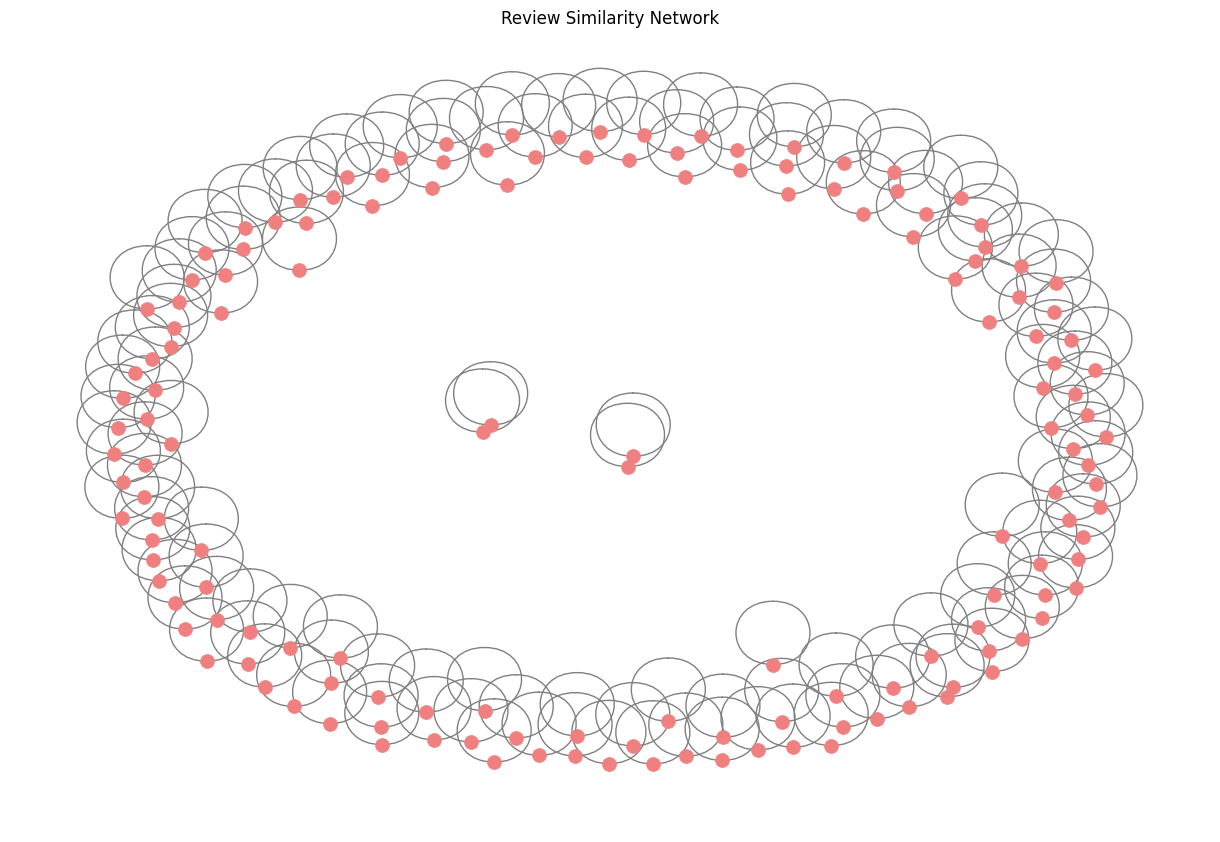

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vectorize reviews
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

# Calculate cosine similarity matrix
cos_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Threshold cosine similarity values
threshold = 0.5
cos_sim_matrix[cos_sim_matrix < threshold] = 0

# Create graph
G_similarity = nx.Graph(cos_sim_matrix)

# Visualize network
plt.figure(figsize=(12, 8))
pos_similarity = nx.spring_layout(G_similarity)
nx.draw(G_similarity, pos_similarity, with_labels=False, node_size=100, node_color='lightcoral', edge_color='gray', linewidths=0.5, arrowsize=10)
plt.title('Review Similarity Network')
plt.show()

Keyword Co-occurrence Network: Construct a network where nodes represent keywords extracted from reviews and edges represent the co-occurrence of keywords in the same review.

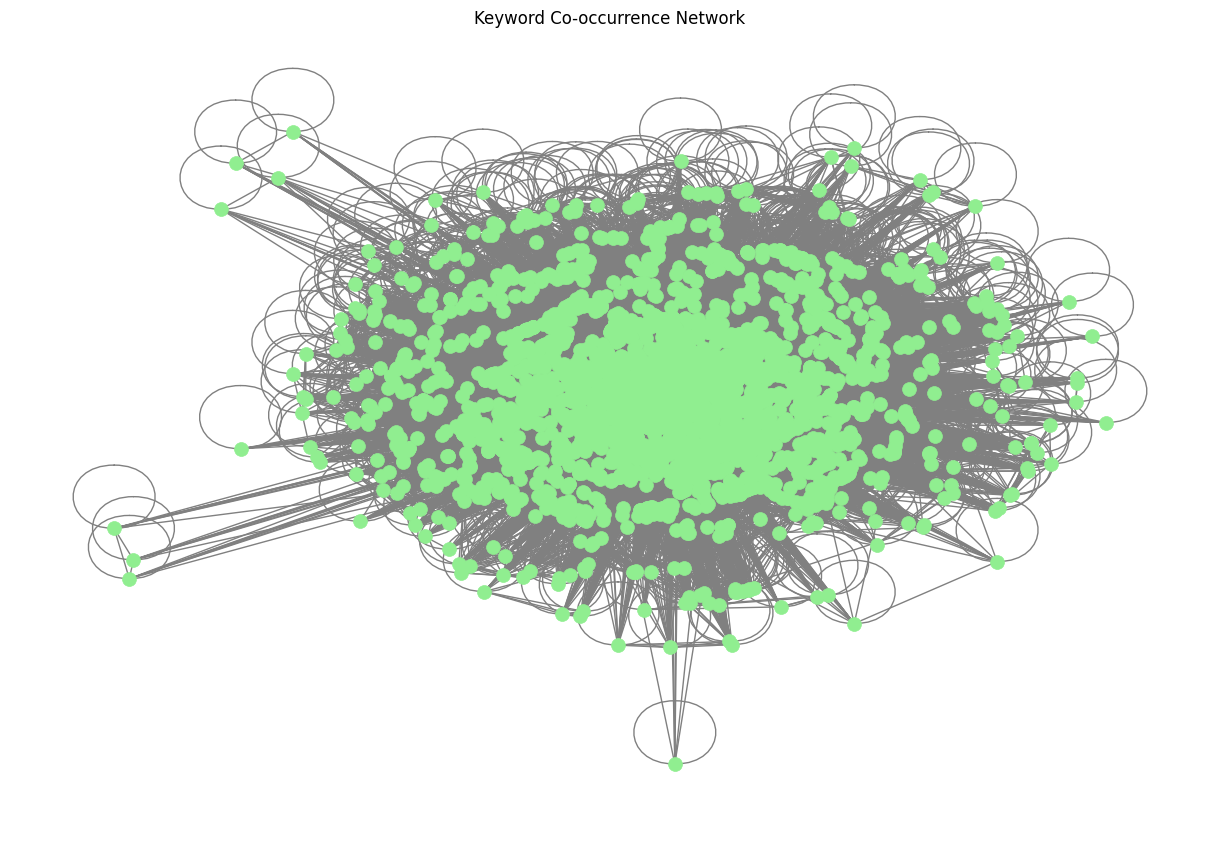

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

# Extract keywords from reviews
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text'])

# Calculate co-occurrence matrix
co_occurrence_matrix = (X.T * X)
co_occurrence_matrix.setdiag(0)

# Create graph
G_co_occurrence = nx.Graph(co_occurrence_matrix)

# Visualize network
plt.figure(figsize=(12, 8))
pos_co_occurrence = nx.spring_layout(G_co_occurrence)
nx.draw(G_co_occurrence, pos_co_occurrence, with_labels=False, node_size=100, node_color='lightgreen', edge_color='gray', linewidths=0.5, arrowsize=10)
plt.title('Keyword Co-occurrence Network')
plt.show()

Temporal Network: Construct a network where nodes represent reviewers or reviews, and edges represent the temporal relationships between them, such as reviews written by the same reviewer within a certain time frame.

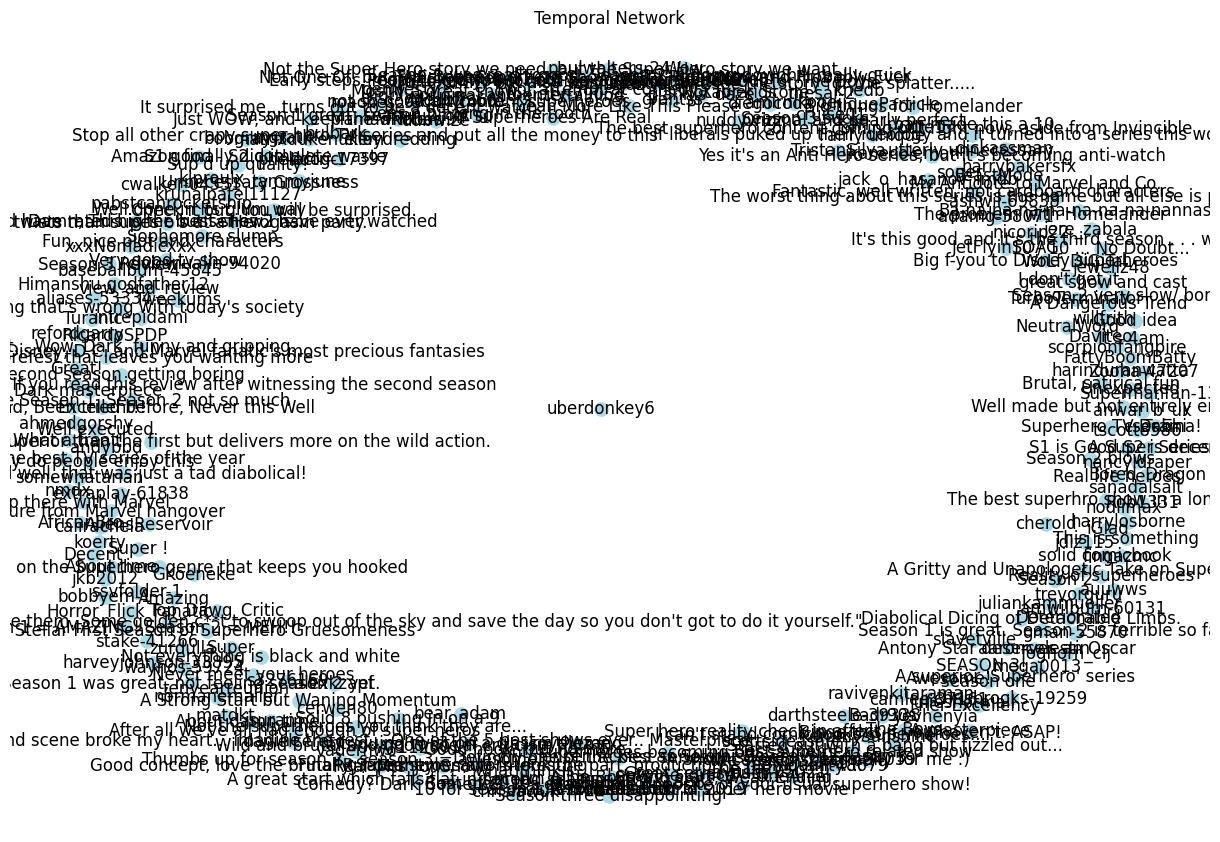

In [8]:
# Example: Construct temporal network based on review dates
G_temporal = nx.Graph()

# Add nodes (reviewers or reviews)
G_temporal.add_nodes_from(df['display-name-link'], bipartite=0)  # Add reviewers as nodes
G_temporal.add_nodes_from(df['title'], bipartite=1)  # Add reviews as nodes

# Add edges based on temporal relationships (e.g., reviews written by the same reviewer within a month)
# You can define your own temporal relationships based on your dataset
for reviewer, group in df.groupby('display-name-link'):
    for _, review_row in group.iterrows():
        review_date = pd.to_datetime(review_row['review-date'])
        for _, other_review_row in group.iterrows():
            other_review_date = pd.to_datetime(other_review_row['review-date'])
            if review_row['title'] != other_review_row['title'] and abs((review_date - other_review_date).days) <= 30:
                G_temporal.add_edge(review_row['display-name-link'], other_review_row['display-name-link'])

# Visualize network
plt.figure(figsize=(12, 8))
pos_temporal = nx.spring_layout(G_temporal)
nx.draw(G_temporal, pos_temporal, with_labels=True, node_size=100, node_color='lightblue', edge_color='gray', linewidths=0.5, arrowsize=10)
plt.title('Temporal Network')
plt.show()